In [1]:
import pandas as pd

In [2]:

def load_data(i_thres):
    def neighbor_ftr(total_or_type, i):
        total_or_type = '-total' if total_or_type else ''
        df_db_binary = pd.read_csv('spatial-corr/moran-i-distanceband-binary%s.csv' % total_or_type, index_col=0)
        db_150 = df_db_binary.db_b == 150
        sig_rand = df_db_binary.p_rand < 0.05
        pass_i_thres = df_db_binary.I.abs() >= i
        keep_cols = df_db_binary[db_150 & sig_rand & pass_i_thres].column
        keep_cols = (keep_cols + '_neighbor').tolist()
        return keep_cols

    def features(keep_categories, total_or_type):
        fn = 'data/x_TOTAL_~2014_cols_by_type.pkl' if total_or_type else 'data/x_NO_TOTAL_~2014_cols_by_type.pkl'
        cols_dict = pickle.load(open(fn, 'rb'))
        keep_ftr = []
        for ftr_type, ftr_cols in cols_dict.items():
            if ftr_type in keep_categories:
                keep_ftr += ftr_cols
        return keep_ftr

    # different type of columns
    rcol_type = features(ROAD_NET_FTR, IS_TYPE)
    scol_type = features(SEGMENT_FTR, IS_TYPE)
    nb_col_type = neighbor_ftr(IS_TYPE, i_thres)
    nb_rcol_type = [c + '_neighbor' for c in rcol_type if c + '_neighbor' in nb_col_type]
    nb_scol_type = [c + '_neighbor' for c in scol_type if c + '_neighbor' in nb_col_type]

    rcol_total = features(ROAD_NET_FTR, IS_TOTAL)
    scol_total = features(SEGMENT_FTR, IS_TOTAL)
    nb_col_total = neighbor_ftr(IS_TOTAL, i_thres)
    nb_rcol_total = [c + '_neighbor' for c in rcol_total if c + '_neighbor' in nb_col_total]
    nb_scol_total = [c + '_neighbor' for c in scol_total if c + '_neighbor' in nb_col_total]

    # self and neighbor features
    x_nb_type = pd.read_csv('spatial-corr/x-neighbor-db-150-binary.csv', index_col=0).fillna(0)
    x_nb_total = pd.read_csv('spatial-corr/x_total-neighbor-db-150-binary.csv', index_col=0).fillna(0)
    x_type = pd.read_csv('data/x_NO_TOTAL_~2014.csv',index_col=0)
    x_total = pd.read_csv('data/x_TOTAL_~2014.csv',index_col=0)

    # final feature
    Xs = {}
    Xs['RoadNet+Spatial'] = x_type[rcol_type].join(x_nb_type[nb_rcol_type])
    Xs['Social type+Spatial'] = x_type[scol_type].join(x_nb_type[nb_scol_type])
    Xs['RoadNet+Social type+Spatial'] = x_type[rcol_type+scol_type].join(x_nb_type[nb_rcol_type+nb_scol_type])

    Xs['Social total+Spatial'] = x_total[scol_total].join(x_nb_total[nb_scol_total])
    Xs['RoadNet+Social total+Spatial'] = x_total[rcol_total+scol_total].join(x_nb_total[nb_rcol_total+nb_scol_total])

    return Xs

In [3]:
import pickle

ROAD_NET_FTR = ['seg_attr', 'net_SaN', 'net_SaE', 'bk_osm', 'bk_opendc', 'elevation']
SEGMENT_FTR = ['poi', 'crash', '311', 'v0', 'crime', 'moving', 'parking']
IS_TOTAL = True
IS_TYPE = False

# spatial I>0.68
Xs= load_data(0.68)
X = Xs['RoadNet+Social type+Spatial']

In [4]:

def init_model_params(name):
    params = grid_cv_default_params()
    if name == 'XGBcls':
        model = xgboost.XGBClassifier()
        param = params['cls']['XGBcls']
    elif name == 'BAGcls':
        model = BaggingClassifier()
        param = params['cls']['BAGcls']
    else:
        raise ('no model')
    return model, param

In [5]:

from wKit.ML.sk_ml import grid_cv_a_model, grid_cv_default_params, evaluator_scalable_cls

import xgboost

In [6]:
scheme = {'default':'data/y_csl_all-2017-10-01.csv', 'familarity': 'data/y_csl_all_fam_include_noinfo-2017-10-01.csv', 
          'experience': 'data/y_csl_all_amplify_fcir-2017-10-01.csv'}
scheme_name = 'default'
scheme_name = 'experience'


print(scheme_name)
csl = pd.read_csv(scheme[scheme_name], index_col=0)
y = csl.csl
target_index_seg = y.index

experience


In [7]:
train_x = X.loc[target_index_seg]

In [8]:
model_name='XGBcls'
model, param = init_model_params(model_name)
cv_path = 'experiment_1001/whole-dc/%s' % scheme_name
grid_res = grid_cv_a_model(train_x, y, model, param, kind=model_name[-3:],
                           name=model_name,
                           path=cv_path)
model = grid_res.pop('best_model')

loading existing model cls XGBcls
loaded existing result for model: XGBcls


In [9]:
pred_y = model.predict(X)

In [28]:
# pd.DataFrame(pred_y, index=X.index, columns=['whole-pred']).to_csv('Pred_y_whole_dc_5lvl_spatial_%s.csv' % scheme_name)

In [57]:
prob = pd.DataFrame(model.predict_proba(X), columns=['very dangerous', 'dangerous', 'normal', 'safe', 'very safe'])

In [58]:
prob['probability'] = prob.apply(lambda x: x.max(), axis=1)

In [62]:
prob['pred_y'] = pred_y

In [63]:
prob.index= X.index

In [64]:
prob['true_y'] = csl.round()

In [65]:
%matplotlib inline

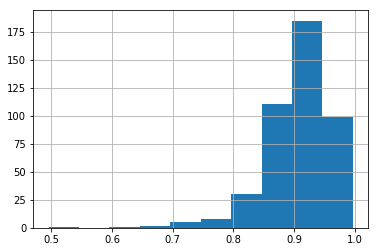

In [66]:
prob[~prob['true_y'].isnull()].probability.hist()

In [70]:
prob.to_csv('Pred_y_with_prob_whole_dc_5lvl_spatial_%s.csv' % scheme_name)

In [71]:
prob

,very dangerous,dangerous,normal,safe,very safe,probability,pred_y,true_y
index_seg,,,,,,,,
0,0.001213,0.039902,0.567872,0.362251,0.028763,0.567872,3.0,NaN
1,0.000422,0.013141,0.263526,0.717442,0.005469,0.717442,4.0,NaN
2,0.001024,0.025082,0.299265,0.668015,0.006615,0.668015,4.0,NaN
3,0.011100,0.122955,0.279144,0.555870,0.030931,0.555870,4.0,NaN
4,0.001983,0.100696,0.314261,0.570618,0.012442,0.570618,4.0,NaN
5,0.002158,0.094470,0.364176,0.520532,0.018664,0.520532,4.0,NaN
6,0.002646,0.098605,0.260965,0.616981,0.020803,0.616981,4.0,NaN
7,0.002627,0.223580,0.357798,0.400243,0.015752,0.400243,4.0,NaN
8,0.001679,0.016307,0.803707,0.166228,0.012079,0.803707,3.0,NaN
